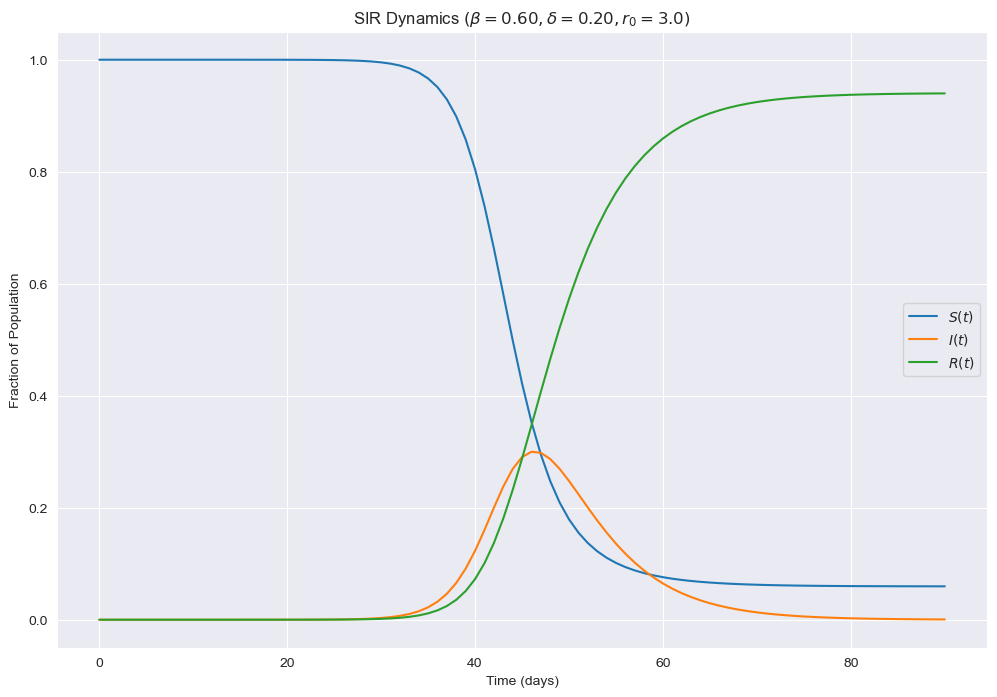

In [107]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
from scipy.integrate import odeint

# True SIR parameters for data generation
N = 56e6  # Total population (for scaling)
delta = 1 / 5  # Recovery rate (per day), assumed known
r0 = 3.0  # basic reproduction number
beta_true = delta * r0  # True infection rate to be learned (per day)


def sir(x, _, d, b):
  s, i, r = x
  l = b * i  #             λ = βI
  ds_dt = -l * s  #        -λS
  di_dt = l * s - d * i  # λS - δI
  dr_dt = d * i  #         δI
  return np.array([ds_dt, di_dt, dr_dt])


# Initial conditions (actual population counts)
S0 = N - 1
I0 = 1
R0 = 0

# Time domain for simulation
t_start, t_end = 0, 90  # days
t = np.linspace(t_start, t_end, t_end - t_start + 1)

# Scale initial conditions to fractions of the population
S0_sc = S0 / N
I0_sc = I0 / N
R0_sc = R0 / N

solution = odeint(sir, [S0_sc, I0_sc, R0_sc], t, args=(delta, beta_true))
s_true = solution[:, 0]
i_true = solution[:, 1]
r_true = solution[:, 2]

plt.subplots(figsize=(12, 6))

sns.lineplot(x=t, y=s_true, label=r"$S(t)$")
sns.lineplot(x=t, y=i_true, label=r"$I(t)$")
sns.lineplot(x=t, y=r_true, label=r"$R(t)$")

plt.title(
  f"SIR Dynamics $\\left(\\beta={beta_true:.2f}, \\delta={delta:.2f}, r_0={r0}\\right)$"
)
plt.xlabel("Time (days)")
plt.ylabel("Fraction of Population")

plt.show()
# plt.savefig(f"{figures_dir}/synthetic_data.png")

In [108]:
obs_t = t
# obs_I = np.random.poisson(i_true)
obs_I = i_true

# Convert observation data to torch tensors for training
obs_t_tensor = torch.tensor(obs_t, dtype=torch.float32).reshape(-1, 1)
I_obs_tensor = torch.tensor(obs_I, dtype=torch.float32).reshape(-1, 1)

# Hyperparameters
n_collocation = 100  # number of collocation points sampled per iteration
n_iterations = 60000  # training iterations for Adam optimizer
log_interval = 1000  #
learning_rate = 1e-3  # learning rate for Adam

# Loss weights for PDE, initial condition, and data components
w_pde = 1.0
w_ic = 10.0
w_data = 1.0

# Initial guess for unknown parameter β
beta_initial_guess = 0.3


In [109]:
import torch.nn as nn


# Define a fully-connected neural network (FNN) for one compartment (S, I, or R)
class FNN(nn.Module):
  def __init__(
      self,
      input_dim=1,
      output_dim=1,
      hidden_layers=[64, 64, 64, 64],
      activation=nn.Tanh()
  ):
    super(FNN, self).__init__()
    layers = []
    prev_dim = input_dim
    # Hidden layers
    for h in hidden_layers:
      layers.append(nn.Linear(prev_dim, h))
      layers.append(activation)
      prev_dim = h
    # Output layer
    layers.append(nn.Linear(prev_dim, output_dim))
    self.model = nn.Sequential(*layers)
    # Initialize weights and biases (Xavier initialization for weights, zeros for biases)
    for m in self.model:
      if isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight)
        nn.init.zeros_(m.bias)

  def forward(self, x):
    return self.model(x)


# Instantiate separate networks for S(t), I(t), and R(t)
S_net = FNN()
I_net = FNN()
R_net = FNN()

# Define β as a trainable parameter
beta_param = torch.nn.Parameter(
  torch.tensor(beta_initial_guess, dtype=torch.float32)
)

# Collect all parameters for the optimizer
params = list(S_net.parameters()) + list(I_net.parameters()) + list(
  R_net.parameters()
) + [beta_param]

# Set up the Adam optimizer
optimizer = torch.optim.Adam(params, lr=learning_rate)


In [110]:
# Define mean squared error loss function
mse_loss = nn.MSELoss()


# Helper: compute SIR ODE residuals at given time points t
def compute_pde_residuals(t):
  """Compute residuals of SIR ODE at times t.
  Returns res_S, res_I, res_R as tensors of the same shape as t."""
  # Ensure t is set for autograd
  t = t.detach().clone().requires_grad_(True)
  # Network predictions
  S_pred = S_net(t)
  I_pred = I_net(t)
  R_pred = R_net(t)
  # Time derivatives via autograd
  dS_dt = torch.autograd.grad(
    S_pred,
    t,
    grad_outputs=torch.ones_like(S_pred),
    create_graph=True
  )[0]
  dI_dt = torch.autograd.grad(
    I_pred,
    t,
    grad_outputs=torch.ones_like(I_pred),
    create_graph=True
  )[0]
  dR_dt = torch.autograd.grad(
    R_pred,
    t,
    grad_outputs=torch.ones_like(R_pred),
    create_graph=True
  )[0]
  # ODE residuals (using scaled variables so N=1 in equations)
  res_S = dS_dt + beta_param * S_pred * I_pred  # = 0 for true solution
  res_I = dI_dt - beta_param * S_pred * I_pred + delta * I_pred  # = 0 for true solution
  res_R = dR_dt - delta * I_pred  # = 0 for true solution
  return res_S, res_I, res_R


# Loss component: ODE/PDE (physics) loss
def loss_pde(t_coll):
  res_S, res_I, res_R = compute_pde_residuals(t_coll)
  # Compute MSE for each residual against 0
  loss_res_S = mse_loss(res_S, torch.zeros_like(res_S))
  loss_res_I = mse_loss(res_I, torch.zeros_like(res_I))
  loss_res_R = mse_loss(res_R, torch.zeros_like(res_R))
  return loss_res_S + loss_res_I + loss_res_R


# Loss component: initial condition loss at t=0
def loss_ic():
  t0_tensor = torch.tensor([[0.0]], dtype=torch.float32)
  S0_pred = S_net(t0_tensor)
  I0_pred = I_net(t0_tensor)
  R0_pred = R_net(t0_tensor)
  # MSE for each initial condition
  loss_S0 = (S0_pred - S0_sc) ** 2
  loss_I0 = (I0_pred - I0_sc) ** 2
  loss_R0 = (R0_pred - R0_sc) ** 2
  # sum (or equivalently average, up to weight scaling) the three
  return loss_S0 + loss_I0 + loss_R0


# Loss component: observation data loss at known data points
def loss_data():
  I_pred = I_net(obs_t_tensor)
  # MSE on each compartment's observed values
  loss_I = mse_loss(I_pred, I_obs_tensor)
  return loss_I


In [111]:
# Training loop
pde_losses = []
ic_losses = []
data_losses = []
total_losses = []
beta_history = []

for it in range(1, n_iterations + 1):
  optimizer.zero_grad()
  # Sample random collocation points in the time domain
  t_coll = torch.rand(n_collocation, 1) * t_end  # uniform random in [0, 90]
  # Compute individual loss components
  L_pde = loss_pde(t_coll)
  L_ic = loss_ic()
  L_data = loss_data()
  # Combine losses with weights
  loss = w_pde * L_pde + w_ic * L_ic + w_data * L_data
  # Backpropagation and optimizer step
  loss.backward()
  optimizer.step()
  # Log losses and beta
  pde_losses.append(L_pde.item())
  ic_losses.append(L_ic.item())
  data_losses.append(L_data.item())
  total_losses.append(loss.item())
  beta_history.append(beta_param.item())
  # Print progress occasionally
  if it % 1000 == 0:
    print(
      f"Iteration {it}: Total Loss = {loss.item():.3e}, β = {beta_param.item():.4f}"
    )


Iteration 1000: Total Loss = 2.953e-03, β = 0.2527
Iteration 2000: Total Loss = 2.755e-03, β = 0.2397
Iteration 3000: Total Loss = 2.247e-03, β = 0.2459
Iteration 4000: Total Loss = 3.000e-03, β = 0.2494
Iteration 5000: Total Loss = 2.193e-03, β = 0.2552
Iteration 6000: Total Loss = 5.223e-04, β = 0.2917
Iteration 7000: Total Loss = 3.509e-04, β = 0.3358
Iteration 8000: Total Loss = 5.284e-05, β = 0.4701
Iteration 9000: Total Loss = 1.737e-05, β = 0.5325
Iteration 10000: Total Loss = 5.009e-06, β = 0.5565
Iteration 11000: Total Loss = 9.284e-05, β = 0.5421
Iteration 12000: Total Loss = 3.414e-05, β = 0.5695
Iteration 13000: Total Loss = 2.310e-06, β = 0.5709
Iteration 14000: Total Loss = 2.706e-06, β = 0.5740
Iteration 15000: Total Loss = 2.058e-04, β = 0.5710
Iteration 16000: Total Loss = 1.769e-05, β = 0.5795
Iteration 17000: Total Loss = 6.662e-05, β = 0.5652
Iteration 18000: Total Loss = 4.444e-05, β = 0.5818
Iteration 19000: Total Loss = 9.565e-06, β = 0.4890
Iteration 20000: Tota

In [80]:
import numpy as np

# Convert logs to numpy arrays for saving
iterations = np.arange(1, n_iterations + 1)
loss_array = np.vstack(
  [iterations, pde_losses, ic_losses, data_losses, total_losses]
).T
beta_array = np.vstack([iterations, beta_history]).T

# Save loss history to CSV (columns: iteration, pde_loss, ic_loss, data_loss, total_loss)
np.savetxt(
  "loss_history.csv",
  loss_array,
  delimiter=",",
  header="iteration,pde_loss,ic_loss,data_loss,total_loss",
  comments="",
  fmt="%.6e"
)

# Save beta history to CSV (columns: iteration, beta)
np.savetxt(
  "beta_history.csv",
  beta_array,
  delimiter=",",
  header="iteration,beta",
  comments="",
  fmt="%.6e"
)

print("Training logs saved: loss_history.csv, beta_history.csv")
print(f"Learned β value = {beta_param.item():.4f} (true value = {beta_true})")


Training logs saved: loss_history.csv, beta_history.csv
Learned β value = 0.5503 (true value = 0.6000000000000001)


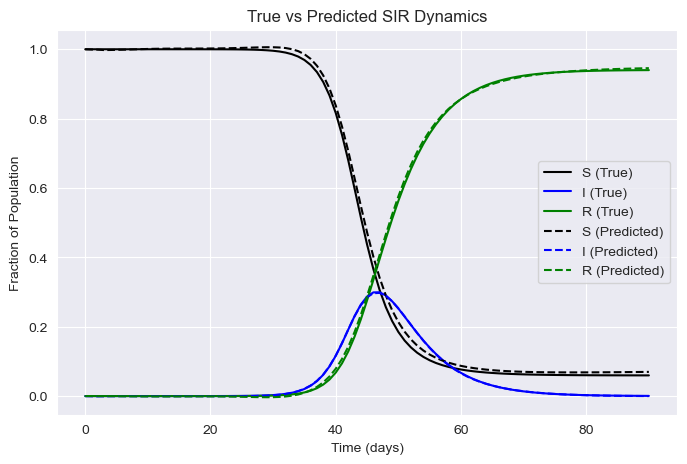

In [81]:
import matplotlib.pyplot as plt

# 1. Plot true vs predicted S, I, R over time
t_plot = t_points  # use the original daily time points for plotting
t_plot_tensor = torch.tensor(t_plot, dtype=torch.float32).reshape(-1, 1)
S_pred = S_net(t_plot_tensor).cpu().detach().numpy().flatten()
I_pred = I_net(t_plot_tensor).cpu().detach().numpy().flatten()
R_pred = R_net(t_plot_tensor).cpu().detach().numpy().flatten()
t_plot_tensor = t_plot_tensor.cpu()

plt.figure(figsize=(8, 5))
plt.plot(t_plot, s_true, 'k', label='S (True)')
plt.plot(t_plot, i_true, 'b', label='I (True)')
plt.plot(t_plot, r_true, 'g', label='R (True)')
plt.plot(t_plot, S_pred, 'k--', label='S (Predicted)')
plt.plot(t_plot, I_pred, 'b--', label='I (Predicted)')
plt.plot(t_plot, R_pred, 'g--', label='R (Predicted)')
plt.xlabel('Time (days)')
plt.ylabel('Fraction of Population')
plt.title('True vs Predicted SIR Dynamics')
plt.legend(loc='best')
plt.grid(True)
plt.savefig("sir_solution_fit.png")

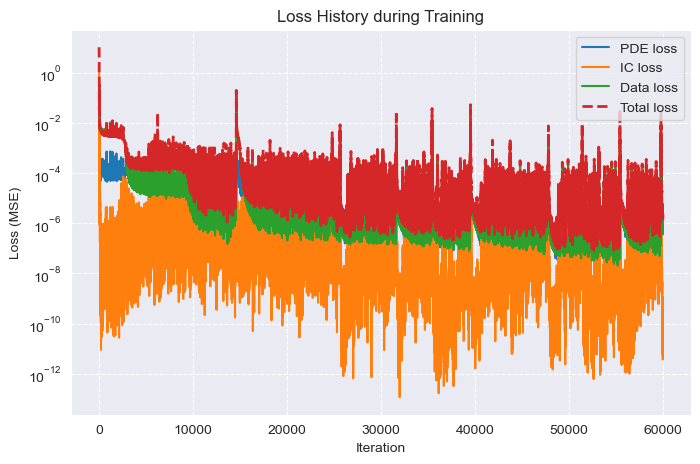

In [82]:
# 2. Plot loss history
plt.figure(figsize=(8, 5))
plt.plot(iterations, pde_losses, label='PDE loss')
plt.plot(iterations, ic_losses, label='IC loss')
plt.plot(iterations, data_losses, label='Data loss')
plt.plot(
  iterations,
  total_losses,
  label='Total loss',
  linewidth=2,
  linestyle='--'
)
plt.yscale('log')
plt.xlabel('Iteration')
plt.ylabel('Loss (MSE)')
plt.title('Loss History during Training')
plt.legend(loc='best')
plt.grid(True, which="both", ls="--")
plt.savefig("loss_history.png")

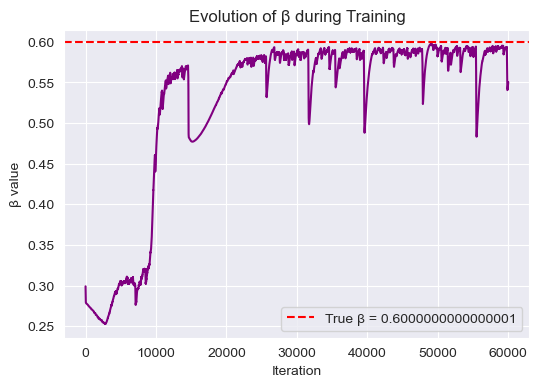

In [83]:
# 3. Plot beta evolution
plt.figure(figsize=(6, 4))
plt.plot(iterations, beta_history, color='purple')
plt.axhline(
  y=beta_true,
  color='r',
  linestyle='--',
  label=f'True β = {beta_true}'
)
plt.xlabel('Iteration')
plt.ylabel('β value')
plt.title('Evolution of β during Training')
plt.legend(loc='best')
plt.grid(True)
plt.savefig("beta_evolution.png")

In [84]:
from IPython.display import display, HTML
import pandas as pd

# Compute MSE on the full time series for S, I, R
mse_S = np.mean((S_pred - s_true) ** 2)
mse_I = np.mean((I_pred - i_true) ** 2)
mse_R = np.mean((R_pred - r_true) ** 2)

re_S = np.linalg.norm(s_true - S_pred, 2) / np.linalg.norm(s_true, 2)
re_I = np.linalg.norm(i_true - I_pred, 2) / np.linalg.norm(i_true, 2)
re_R = np.linalg.norm(r_true - R_pred, 2) / np.linalg.norm(r_true, 2)

beta_error = abs(beta_param.item() - beta_true)
beta_error_percent = beta_error / beta_true * 100

errors = pd.DataFrame(
  {
    'Compartment':    ['S', 'I', 'R'],
    'MSE':            [mse_S, mse_I, mse_R],
    'Relative Error': [re_S, re_I, re_R]
  }
)

errors['MSE'] = errors['MSE'].map('{:.2e}'.format)
errors['Relative Error'] = errors['Relative Error'].map('{:.2f}'.format)

display(HTML(errors.to_html(index=False)))

print(f"Learned β: {beta_param.item():.4f} (true β: {beta_true})")
print(
  f"β estimation error: {beta_error:.2e} ({beta_error_percent:.2f}% relative error)"
)


Compartment,MSE,Relative Error
S,2.02e-04,0.02
I,4.35e-07,0.01
R,3.30e-05,0.01


Learned β: 0.5503 (true β: 0.6000000000000001)
β estimation error: 4.97e-02 (8.28% relative error)
